1.Importing libraries

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as pltV
import time
import mediapipe as mp
from processing_utils import draw_styled_landmarsks , mediapipe_detection , extract_keypoints 
from processing_utils import make_dir , collecting_data , explore_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

2. Keypoints using MP Holistic

In [2]:
mp_holistic_model = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 

3. Explore the model

In [31]:
explore_model(mp_holistic_model , mp_drawing)

Data shape is (132,)


4. Setup Folders for Collection

In [4]:
#that is the path for exported data
DATA_PATH = os.path.join('mediapipe_data')
#actions we are tring to predict
actions = np.array(['open' , 'put' , 'close' , 'stand'])
# 70 seq for each action
no_sequences = 250
# videos are going to be 35 frames
sequences_length = 50

In [5]:
make_dir(DATA_PATH , actions , no_sequences)

Directory already created !


5. Collect Keypoint Values for each action

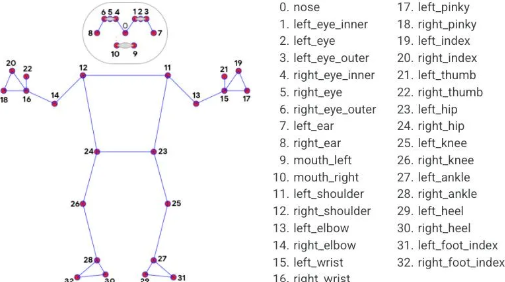

In [6]:
#collecting_data(mp_holistic_model , mp_drawing, 'open' , 0 , no_sequences , sequences_length , DATA_PATH)

In [7]:
#collecting_data(mp_holistic_model , mp_drawing, 'put' , 0 ,  no_sequences , sequences_length , DATA_PATH)

In [8]:
#collecting_data(mp_holistic_model , mp_drawing, 'stand',0 , no_sequences , sequences_length , DATA_PATH)

In [9]:
#collecting_data(mp_holistic_model , mp_drawing, 'close' ,0 , no_sequences , sequences_length , DATA_PATH)

6. Preprocess Data and Create Labels and Features

In [10]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [11]:
actions = np.array(['open' , 'put' , 'stand' ])

label_map = {label:num for num , label in enumerate(actions)}

In [12]:
label_map

{'open': 0, 'put': 1, 'stand': 2}

In [13]:
sequences , labels = [] , []
for action in actions :
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequences_length):
            res = np.load(os.path.join(DATA_PATH , action , str(sequence) , '{}.npy'.format(frame_num))) 
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])


In [14]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X , y, shuffle=True , test_size=0.2)

In [16]:
X_train.shape

(600, 50, 132)

In [17]:
y_train.shape

(600, 3)

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense , Dropout
from keras.callbacks import TensorBoard
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')


def create_model(): 
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


    model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(50,132)),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.1)  , 
    Dense(3, activation='softmax')])
    adam = tf.keras.optimizers.Adam(
        learning_rate=0.0001, # that small learning rate is very important
        beta_1=0.9,
        beta_2=0.999)

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [39]:
model = create_model()

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 64)            50432     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 87,811
Trainable params: 87,811
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X ,y   , epochs=20,  batch_size=10 )

Epoch 1/20
75/75 [==============================] - 4s 29ms/step - loss: 1.0758 - categorical_accuracy: 0.4587
Epoch 2/20
75/75 [==============================] - 2s 30ms/step - loss: 0.5216 - categorical_accuracy: 0.8333
Epoch 3/20
75/75 [==============================] - 2s 29ms/step - loss: 0.1453 - categorical_accuracy: 0.9600
Epoch 4/20
75/75 [==============================] - 2s 29ms/step - loss: 0.0567 - categorical_accuracy: 0.9773
Epoch 5/20
75/75 [==============================] - 2s 29ms/step - loss: 0.0600 - categorical_accuracy: 0.9760
Epoch 6/20
75/75 [==============================] - 2s 30ms/step - loss: 0.0211 - categorical_accuracy: 0.9947
Epoch 7/20
75/75 [==============================] - 2s 29ms/step - loss: 0.0232 - categorical_accuracy: 0.9960
Epoch 8/20
75/75 [==============================] - 2s 30ms/step - loss: 0.0727 - categorical_accuracy: 0.9787
Epoch 9/20
75/75 [==============================] - 2s 30ms/step - loss: 0.0419 - categorical_accuracy: 0.9893
E

In [42]:
model.save('action.h5')

7. calling the model and start testing

In [43]:
from tensorflow import keras
model = keras.models.load_model('action.h5')

In [44]:
colors = (16 , 117 , 245)
def prob_viz(res , actions , input_frame , colors):
    output_frame = input_frame.copy()
    for num , prob in enumerate(res):
        cv2.rectangle(output_frame , (0 , 60 + num * 40 ) , #start_point : represents the top left corner of rectangle
            (int(prob * 100) ,  90 + num* 40 ), #end_point : represents the bottom right corner of rectangle
            colors , -1
                )
        cv2.putText(output_frame, actions[num]
            , (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX
            , 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame


In [62]:
# detection variables
sentence = []
sequence = []
predictions = []
threshold = 0.99

cap = cv2.VideoCapture(0)
# Getting the settings of our video capture
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

writ = cv2.VideoWriter('keyPointRecognition.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (frame_width,frame_height))

# Set mediapipe model 
with mp_holistic_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarsks(mp_drawing , mp_holistic_model ,image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-50:]
        
        if len(sequence) == 50:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
            if np.unique(predictions[-50:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    predictions = []
                    sequence = []
                    time.sleep(1)


                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                
                    
            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)





        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        writ.write(image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    writ.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti